In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [14]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.C = C
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # Backprop
#         dX = dout @ W_fixed.T # fb alignment
#         dX = dout @ np.linalg.inv(W_fixed)

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward include in dcross_entropy
#         dy *= ys[2] - ys_prev[2] # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_prob = nn.test(X_test)
        loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [15]:
# Hyper-parameters
n_iter = 1000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.2969 valid loss: 2.2927, valid accuracy: 0.1260
Iter-20 train loss: 2.2682 valid loss: 2.2890, valid accuracy: 0.1334
Iter-30 train loss: 2.2985 valid loss: 2.2850, valid accuracy: 0.1434
Iter-40 train loss: 2.2638 valid loss: 2.2814, valid accuracy: 0.1498
Iter-50 train loss: 2.2819 valid loss: 2.2776, valid accuracy: 0.1570
Iter-60 train loss: 2.2725 valid loss: 2.2737, valid accuracy: 0.1670
Iter-70 train loss: 2.2548 valid loss: 2.2699, valid accuracy: 0.1734
Iter-80 train loss: 2.2784 valid loss: 2.2665, valid accuracy: 0.1802
Iter-90 train loss: 2.2825 valid loss: 2.2628, valid accuracy: 0.1884
Iter-100 train loss: 2.2631 valid loss: 2.2590, valid accuracy: 0.1976
Iter-110 train loss: 2.2679 valid loss: 2.2551, valid accuracy: 0.2088
Iter-120 train loss: 2.2529 valid loss: 2.2513, valid accuracy: 0.2206
Iter-130 train loss: 2.2524 valid loss: 2.2475, valid accuracy: 0.2302
Iter-140 train loss: 2.2442 valid loss: 2.2439, valid accuracy: 0.2382
Iter-150 train 

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


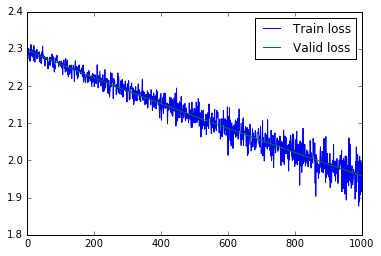

In [16]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

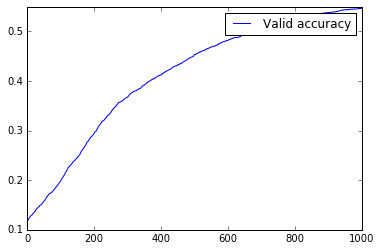

In [17]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()